In [4]:
#we’ll use the dataset of papers published in NeurIPS (NIPS) conference
import pandas as pd
import os

# importing paper data 
papers = pd.read_csv('papers.csv')
# head 
print(len(papers))
#papers.head()
# removing some metadata columns such as id, event type and pdf name, sampling 200 rows or 200 papers
paper_cleaned = papers.drop(columns = ['id', 'pdf_name', 'event_type'], axis =1).sample(200) 
# remove punctuation and upper case
import re 
def clean_txt(txt):
    #text = re.sub(r'[m+ -- \[*. \??* \d+ \^ \s]', '', txt)
    text = re.sub('--', '', txt)
    text = re.sub('[\[].*?[\]]', '', text)
    text = re.sub('(\b|\s+\-?|^\-?)(\d+|\d*\.\d+ )\b','', text)
    text = re.sub('\n', ' ', txt)
    return text
paper_cleaned['processed_text'] = paper_cleaned['paper_text'].map(lambda x: clean_txt(x))
paper_cleaned['processed_text'] = paper_cleaned['processed_text'].map(lambda x: x.lower())

# print out the first 10 rows of the processed text
paper_cleaned['processed_text'].head(10)


7241


6134    automated scalable segmentation of neurons fro...
1052    laplacian eigenmaps and spectral techniques fo...
1511    an mcmc-based method of comparing connectionis...
7020    robust parameter estimation and model selectio...
5601    mixed vine copulas as joint models of spike co...
5668    reconstructing parameters of spreading models ...
5156    variational information maximisation for intri...
6585    high-order attention models for visual questio...
6102    computation of heading direction from optic fl...
5970    improved regret bounds for oracle-based advers...
Name: processed_text, dtype: object

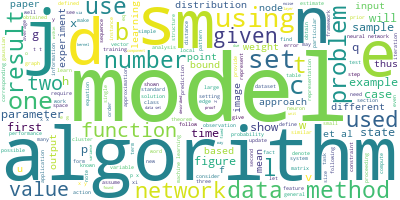

In [5]:
# import wordcloud library
#!pip install WordCloud
from wordcloud import WordCloud
# combining the text in all papers, so that we apply text modelling
All_papers = ','.join(list(paper_cleaned['processed_text'].values))
# Create a WordCloud object
wc = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wc.generate(All_papers)
# Visualize the word cloud
wc.to_image()

Tokenisieren Sie den Text und entfernen Sie Stoppwörter

In [8]:
# tokenization of the text before training LDA model 
# using gensim simple_preprocess function we lowercase, tokenize, de-accent the text
# tokens are unicode strings of a set of charaters those have a meaning together.
import gensim
import nltk
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords

# stop words of the English dictionary
stop_w = stopwords.words('English')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use','of', 'as', 'by', 'uc'])
# we use yield generator and not return when we want to iterate over a sequence, but don't want to store the entire sequence in memory.

def doc_to_tokens(text):
    for doc in text:
        # deacc=True removes accent
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))# tokenize each document
        
def rm_stopwords(texts):
    wrds = [[word for word in doc if word not in stop_w] for doc in texts]# for each doc in the text, remove stop words
    print(wrds[:1][0][:30])
    return wrds

# joining the paper content in a list of sentences
txt = paper_cleaned.processed_text.values.tolist() # txt is a collection of sentences
tokens = list(doc_to_tokens(txt)) 
#tokens[0][:10]
docs = rm_stopwords(tokens)



[nltk_data] Downloading package stopwords to /Users/ariel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['automated', 'scalable', 'segmentation', 'neurons', 'multispectral', 'images', 'uygar', 'mb', 'grossman', 'center', 'statistics', 'mind', 'dept', 'statistics', 'columbia', 'university', 'douglas', 'roossien', 'jr', 'university', 'michigan', 'medical', 'school', 'fei', 'chen', 'mit', 'media', 'lab', 'mcgovern', 'institute']


In [9]:
# create the dictionary of the text to be modelled; a mapping between words and their integer ids
import gensim.corpora as corpo

# build dictionary of the text
word_dict = corpo.Dictionary(docs)

# doc2bow : Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# term frequency
corpus = [word_dict.doc2bow(doc) for doc in docs]

# View
len(corpus)
print(corpus[:1][0][:10])# print out the tupels

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 8), (6, 1), (7, 1), (8, 1), (9, 2)]


1. Erstellen Sie ein Korpuswörterbuch und ein LDA-Modell mit 3 Themen
2. Drucken Sie die 5 häufigsten Wörter pro Thema aus

In [12]:
# training the model
# we will build a model with 10 topics,
# where each topic is a combination of keywords, each keyword holds a specific contribution/weight to the topic.
from pprint import pprint
# building LDA text modelling using all CPU cores to parallelize and speed up model training.
lda_mo = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=word_dict,
                                       num_topics=3)
# Printing the Keywords in the 3 topics
# Get the most significant topics
# num_words: The number of keywords to be included per topics (ordered by significance).
pprint(lda_mo.print_topics( num_words=5))


[(0,
  '0.007*"model" + 0.005*"data" + 0.005*"learning" + 0.005*"algorithm" + '
  '0.004*"set"'),
 (1,
  '0.007*"learning" + 0.006*"data" + 0.006*"algorithm" + 0.005*"model" + '
  '0.004*"set"'),
 (2,
  '0.006*"model" + 0.006*"algorithm" + 0.006*"learning" + 0.005*"data" + '
  '0.004*"time"')]


In [13]:
# Get the most significant topics
# num_words: The number of keywords to be included per topics (ordered by significance).
pprint(lda_mo.print_topics(num_words=5))


[(0,
  '0.007*"model" + 0.005*"data" + 0.005*"learning" + 0.005*"algorithm" + '
  '0.004*"set"'),
 (1,
  '0.007*"learning" + 0.006*"data" + 0.006*"algorithm" + 0.005*"model" + '
  '0.004*"set"'),
 (2,
  '0.006*"model" + 0.006*"algorithm" + 0.006*"learning" + 0.005*"data" + '
  '0.004*"time"')]


In [ ]:
# analyzing LDA model output under using of visualization package, pyLDAvis

#!pip install pyLDAvis
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

# enable automatic D3 display of prepared model data in the IPython notebook.
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    # prepare: transforms the topic model distributions and related corpus data into the data structures needed for the visualization.
    # corpus is the term frequency, word_dict is the vocab parameter,
    # R is the number of terms to display in the barcharts of the visualization. Default is 30
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_mo, corpus, word_dict)#, R= 20)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
#write the visualization to a standalone html file, so that we have later only to read and display
# the file(we don't need to prapare the data for visualization again)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared' +'.html')
LDAvis_prepared
# the outputted 'Estimated term frequency within the selected topic' is derived from topic-term probabilities(given by lda_mo).
# the marginal topic distribution is the “importance” of each topic for the whole corpus:the percentage that the topic makes up in the corpus
